# Error Mitigation using Pauli Propagation

Since hardware related errors on quantum computers can not be fully error corrected yet due to the restricted number of qubits available, many classical techniques have been developed which can account for errors. 
This is known as **Quantum Error Mitigation**, and it's a classical post-processing step for calculations on NISQ-quantum computers. 

The leading error mitigation techniques are zero-noise extrapolation (ZNE) and probabilistic error cancellation (PEC). To get an overview of common methods, the mitiq documentation is very useful (https://mitiq.readthedocs.io/en/stable/guide/guide.html, see the "What is the theory behind ...?" subriders). 

We will focus on an error mitigation technique called Clifford Data Regression (CDR), then compare it to a canonical method (ZNE) and finally combine these 2 methods in order to achieve even better correction. The combined technique is called variable noise CDR (vnCDR). 

CDR was introduced in 2021 (http://arxiv.org/abs/2005.10189), as well as vnCDR (https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.033098). We further take ideas from Clifford Perturbation Approximation (CPA) (http://arxiv.org/abs/2412.09518). 

In [1]:
include("src/cpa.jl")
global_logger(UnbufferedLogger(stdout, MainInfo));

The system we are interested in simulating is the TFIM, where the Hamiltonian is given by
$$
 H = -J\sum_{<i,j>}Z_iZ_j+h\sum_i X_i .
 $$
The first-order Trotterization of the time-dependent Schödinger equation is
$$
\begin{align}
 \ket{\psi(T)} &= \prod_{k=1}^N e^{-i\frac{T}{N}H} \ket{\psi(0)} \\
    &\approx \prod_{k=1}^N \left(\prod_{<i,j>} e^{i \frac{JT}{N}Z_i Z_j } \prod_i e^{-i \frac{hT}{N}X_i} \right) \ket{\psi(0)} \\
    &= \prod_{k=1}^N \left[ \prod_{<i,j>} R_{Z_i Z_j} \left(-\frac{2JT}{N}\right) \prod_i R_{X_i}\left(\frac{2Th}{N}\right) \right] \ket{\psi(0)} .
 \end{align}
 $$


# Clifford Data Regression (CDR)
We are interested in mitigating the errors on the expectation value of a non-Clifford circuit (`exact_expval_target`). We use here a toy example for which we can calculate this exactly with Pauli Propagation, as well as the noisy expectation value (`noisy_expval_target`) we get after applying a noise model (here noise `noise_kind = "gate_ising"`). In real applications, the circuit of interest would not be classically exatcly simulable.
Clifford Data Regression consists of the following steps:
1) Choose circuits $\ket{\phi_i}$ that are efficiently simulable and "close" to the target circuit (i.e. we replace some or all gates). This gives a set of close circuits $S_\psi  = \{\ket{\phi_i}\}$.
2) Generate a training set 
$ \mathcal{T}_\psi  = \{ X_{\phi_i}^{\text{noisy}} , X_{\phi_i}^{\text{exact}} \} $ 
by calculating the exact and noisy expectation values of all circuits in $S_\psi$.
3) Choose an ansatz to define the relation between the noisy and exact data: $ X_\psi^{\text{exact}} = f( X_\psi^{\text{noisy}},\underline{a})$. Learn the parameters $\underline{a}$ and then predict the noiseless expectation value of the target.

### Target circuit data
We start by defining our target circuit and visualizing the time evolution, both exact and with noise. This step can only be done for small and shallow circuits, since we do not use any truncations. For larger computations see the utility experiment example.

In [2]:
nq = 9
steps = 11
T = steps/20 # dt = 0.05
J =  2.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0  #abs(h) < abs(J) in ordered phase
angle_definition = pi/20
trotter = trotter_setup(nq, steps, T, J, h);
observable = obs_interaction(trotter); #⟨ZZ⟩
min_abs_coeff = 0.0;

In [3]:
exact_expval_target = trotter_time_evolution(trotter; observable=observable, record=true, min_abs_coeff=min_abs_coeff, max_weight=Inf);

 Using `noise_kind = "gate_ising"` adds a layer of depolarizing and dephasing noise after each step/layer of the ansatz with a default strength of `depol_strength=0.01`, `dephase_strength=0.01`.

In [4]:
noisy_expval_target = trotter_time_evolution(trotter; observable=observable, noise_kind="gate_ising", record=true, min_abs_coeff=min_abs_coeff);

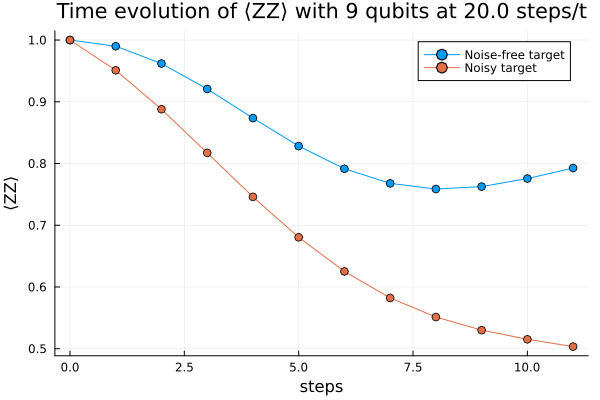

In [5]:
plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
elseif observable == obs_magnetization(trotter)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

### 1) Training data
There are multiple ways to generate the training set for CDR. Since we are interested in the small angle regime (we want a good time resolution of the trotterized evolution), the Clifford perturbation Approximation approach (CPA) is suitable. 

Instead of only allowing for Clifford gate replacements, the replaced gates can be within a small interval around Clifford gates (`angle_definition`).
This allows us to closer approximate the target circuit, while leveraging the fact that PP is efficient for small angles.

We can stick exactly to the scheme introduced in the CPA paper (`training_circuit_generation_strict_perturbation`, with keyword argument `sample_function=CPA`). We have 2 distinct angles in the trotterized circuit, the $R_{ZZ}$ angle $\theta_J = -\frac{2JT}{N}$ and the $R_X$ angle $\theta_h = \frac{2hT}{N}$.
We replace both with a randomly sampled angle, where 
$$\theta_h \in [0,\texttt{angle\_definition}] \cup [\pi/2-\texttt{angle\_definition}, \pi/2]$$
and 
$$ \theta_J \in [-\texttt{angle\_definition},0] \cup [-\pi/2, -\pi/2 +\texttt{angle\_definition}] . $$
If we set `sample_function=small`, we only choose randomly from the interval closer to 0.

A heuristic method derived of this approach is `training_circuit_generation_loose_perturbation`. It keeps the angle at its current value if it is already in the interval written above, and otherwise rounds to the closest boundary of the `angle_definition` interval. This means the time resolution should not be too small, otherwise the training set consists only of the same circuits. To make sure it is not the case, we check that either $\theta_J$ or $\theta_h$ is larger than the `angle_definition`.

Remark on the original CDR approach:
In the original CDR approach, a fixed number of gates are replaced by Clifford gates. In order to guarantee similar expectation values of the training set, one needs to assume further information on the system (such as prior information of the groundstate when observing the energy). Since we do not want to use any prior information for the time evolution, we have to opt for a more expressive approach.

In [6]:
list_training_thetas = training_circuit_generation_loose_perturbation(trotter; sample_function="small", num_samples=7);

### 2) Training set generation

We can use the function `training_trotter_time_evolution` to evolve all the training circuits (with and without noise). With `record = true` we save all steps of the time evolution.

In [7]:
exact_expvals_training = training_trotter_time_evolution(trotter, list_training_thetas; observable=observable, record=true);

In [8]:
noisy_expvals_training = training_trotter_time_evolution(trotter, list_training_thetas; observable=observable, noise_kind="gate_ising", record=true);

We now visualize the evolutions of the circuits. The solid lines represent the noisy and noiseless evolutions of the target circuit . The transparent lines represent the evolution of the training circuits, with a plus marker for noiseless values and a cross marker for the noisy ones.

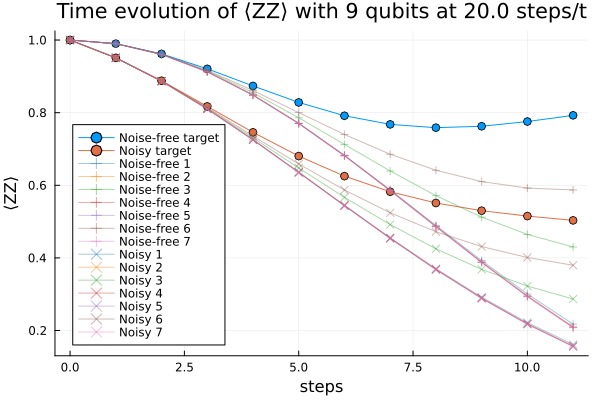

In [9]:
colors = palette(:tab10)

plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o, legend=:bottomleft)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

for (i, exact) in enumerate(exact_expvals_training)
    plot!(0:trotter.steps, exact, label="Noise-free $(i)", c=colors[i], marker=:+, alpha=0.4)
end

for (i, noisy) in enumerate(noisy_expvals_training)
    plot!(0:trotter.steps, noisy, label="Noisy $(i)", color=colors[i], marker=:x, alpha=0.4)
end

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
else
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

### 3) CDR
Just as in the original CDR paper, we start by correcting the noisy expecation value with a linear ansatz. The motivation is that this ansatz is the exact solution for a general quantum erasure noise channel, which takes the input state $\rho$ to
$$
  \rho \rightarrow (1-p_\text{error}) \rho  + p_\text{error}\ \rho_0 .
$$
Thus, we can perform least square regression (which assumes Gaussian noise) to find the optimal parameters $a_1,a_2$ in the following dependency for the noiseless expectation value
$$
X_\psi^{\text{exact}} = f( X_\psi^{\text{noisy}},a )  = a_1 X_\psi^{\text{noisy}} + a_2 .
$$
The function `cdr`gives the final corrected value, and if `use_target = true`, gives the relative error before and after the correction.

To visualize how the CDR correction performs over time, there is a second method `cdr` which calculates the correction for every time step. Note that we cannot correct noise during time evolution, since we only working with the expectation values and cannot reconstruct the corrected state from one expectation value.

Finally, we implemented weighted linear regression as a heuristic alternative, where we can define a vector of decaying weights for previous time steps that then also contribute to the fit.

We first correct only the last step of the time evolution.

In [10]:
noisy_expvals_training_last = [row[end] for row in noisy_expvals_training]
exact_expvals_training_last = [row[end] for row in exact_expvals_training]
noisy_expval_target_last = noisy_expval_target[end]
exact_expval_target_last = exact_expval_target[end]
corr_last, rel_error_after_cdr_last, rel_error_before_cdr_last = cdr(
    noisy_expvals_training_last,
    exact_expvals_training_last,
    noisy_expval_target_last;
    exact_target_exp_value=exact_expval_target_last,
    use_target=true
)
println("Corrected value at the last timestep: $corr_last")
println("Relative error before correction: $rel_error_before_cdr_last")
println("Relative error after correction: $rel_error_after_cdr_last")

Corrected value at the last timestep: 0.796939025284239
Relative error before correction: 0.36497176962332284
Relative error after correction: 0.005341894361122774


We now do CDR for all time steps to visualize the evolution of the correction (only considering the current step).

In [11]:
corrected, rel_after_cdr, rel_before_cdr = cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target; exact_target_exp_value=exact_expval_target, use_target=true
);

We finally look at the decaying weights example, used for weighted linear regression.

In [12]:
#CDR with decaying weights
decay_weights_partial_mem = [
    [τ == t ? 1.0 : (τ == t-1 ? 0.5 : 0.0) for τ in 1:t]
    for t in 1:length(noisy_expvals_training[1])
]
corrected_weight_partial_mem, rel_after_weight_partial_mem, rel_before_weight_partial_mem= cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target, decay_weights_partial_mem; exact_target_exp_value=exact_expval_target, use_target=true
);

decay_weights_linear = [[τ / t for τ in 1:t] for t in 1:length(noisy_expvals_training[1])]
corrected_weight_lin, rel_after_weight_lin, rel_before_weight_lin = cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target, decay_weights_linear; exact_target_exp_value=exact_expval_target, use_target=true
);

We can now compare the variations of the CDR method with each other.

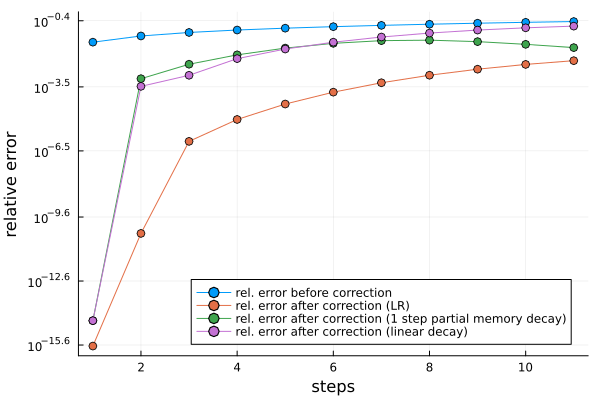

In [13]:
start = 1
# compute 6 log‐spaced y‐tick positions over your data range
ys = vcat(rel_before_cdr[start:end],
          rel_after_cdr[start:end],
          rel_after_weight_lin[start:end],
          rel_after_weight_partial_mem[start:end])
pre_round = range(log10(minimum(ys)), log10(maximum(ys)), length=6)
rounded_ticks = round.(pre_round, digits=1)
ticks = 10 .^ rounded_ticks

plot(start:trotter.steps,
     rel_before_cdr[start:end];
     xlabel="steps",
     ylabel="relative error",
     label="rel. error before correction",
     marker=:o,
     legend=:bottomright,
     yscale=:log10,
     yticks=ticks)
plot!(start:trotter.steps, rel_after_cdr[start:end];
      label="rel. error after correction (LR)",
      marker=:o)
plot!(start:trotter.steps, rel_after_weight_partial_mem[start:end];
      label="rel. error after correction (1 step partial memory decay)",
      marker=:o)
plot!(start:trotter.steps, rel_after_weight_lin[start:end];
      label="rel. error after correction (linear decay)",
      marker=:o)

# ZNE
We now compare our correction to the canonical ZNE method. We first scale the noise of the quantum circuit to higher values, which can be easily done within our implementation. Then we extrapolate to the zero noise expectation value. 

First, we calculate the noisy expectation values at the set `noise_levels`.

In [14]:
noise_levels = [1.0,1.3,1.5,1.8,2.0,2.2]
noisy_expval_target_levels = zne_time_evolution(trotter; observable=observable, noise_levels=noise_levels, noise_kind="gate_ising", record=true);

We look only at the last value of the time evolution for the correction.

In [15]:
noisy_exp_last = noisy_expval_target_levels[:,end]

6-element Vector{Float64}:
 0.5033897242151323
 0.4391520814665356
 0.4009129707045946
 0.3496555701582974
 0.3191463098064843
 0.2912740718076537

Let's look at the data to choose how to fit the zero noise extrapolation. We see that a linear fit is a good idea (An exponential fit might also work).

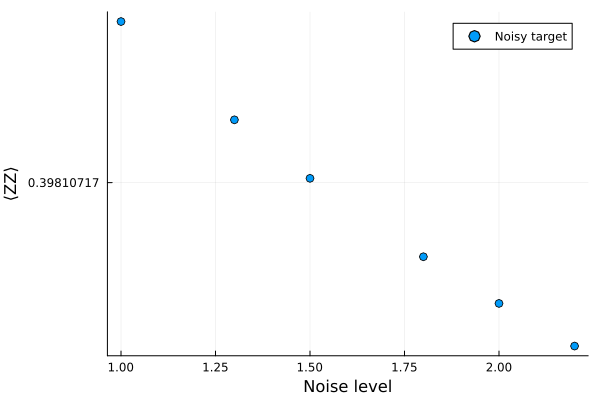

In [34]:
scatter(noise_levels, noisy_exp_last,
     xlabel="Noise level",
     ylabel="⟨ZZ⟩",
     label="Noisy target",
     marker=:o,
     legend=:topright,
     yticks=ticks)

In [17]:
corrected = zne(noisy_exp_last; exact_target_exp_value=exact_expval_target[end],noise_levels =noise_levels, use_target=true)
println("Corrected value: $(corrected[1])")
println("Relative error before correction: $(corrected[3])")
println("Relative error after correction: $(corrected[2])")

Corrected value: 0.6713148997926136
Relative error before correction: 0.36497176962332284
Relative error after correction: 0.15313346233779807


Alternatively, we can perform ZNE at every time step (only considering the current time step, as done for CDR above).

In [18]:
corr_zne, rel_after_zne, rel_before_zne = zne(noisy_expval_target_levels; exact_target_exp_value=exact_expval_target,noise_levels = noise_levels, use_target=true);

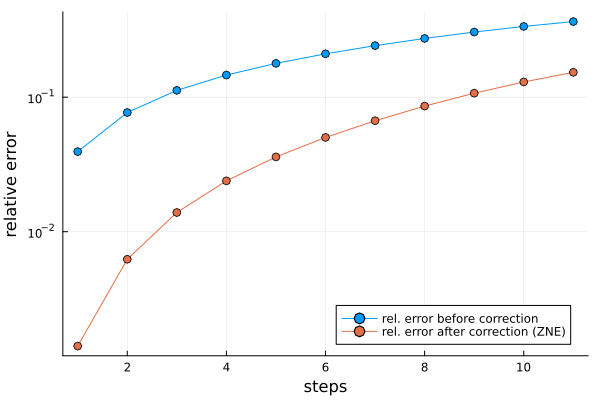

In [19]:
start = 1
plot(1:trotter.steps, rel_before_zne[start:end], xlabel="steps", ylabel="relative error", label="rel. error before correction", marker=:o, legend=:bottomright)
plot!(1:trotter.steps, rel_after_zne[start:end], label="rel. error after correction (ZNE)", marker=:o, yscale=:log10)

# vnCDR
The CDR and ZNE method can be combined to improve the error correction.
For each circuit from the training set, one calculates the expectation value at multiple noise levels, as well as the corresponding noiseless expectation value. Note here that `vnCDR` works with the varied noise levels of the training circuits, while ZNE works with the varied noise levels of the target circuit as shown above.

More precisely, we will be implementing CPDR-ZNE as described in the CPA paper. This is based on the same idea as vnCDR, but allows for a small angle perturbation from Cliffords in the training circuit generation. Aditionally, it uses a Ridge Regression to reduce overfitting.

In [27]:
exact_expvals_training_levels = training_trotter_time_evolution(
    trotter,
    list_training_thetas;
    observable = observable,
    noise_kind = "noiseless",
    record = true
);

In [28]:
noisy_expvals_training_levels = vnCDR_training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, noise_kind="gate_ising",noise_levels = noise_levels, record = true);

In [29]:
noisy_expvals_training_levels_end = noisy_expvals_training_levels[:,:,end];

In [30]:
exact_expvals_training_end = [row[end] for row in exact_expvals_training];

We can use vnCDR for the last step of the time evolution:

In [31]:
pred, rel_after, rel_before = vnCDR(
    noisy_expvals_training_levels_end,
    exact_expvals_training_end,
    noisy_exp_last; exact_target_exp_value = exact_expval_target[end], use_target=true, lambda = 0.0
)
println("Corrected value: $pred")
println("Relative error before correction: $rel_before")
println("Relative error after correction: $rel_after")

Corrected value: 0.792704485630491
Relative error before correction: 0.632556547190116
Relative error after correction: 4.9791491458347716e-9


We can also correct the values for each time step. This is visualized in the last plot. 

In [32]:
corr_vnCDR, rel_after_vnCDR, rel_before_vnCDR = vnCDR(
    noisy_expvals_training_levels,
    exact_expvals_training,
    noisy_expval_target_levels; exact_target_exp_value=exact_expval_target, use_target=true
);

### Comparison plot of all methods
We now plot the final results from vnCDR and compare these to the results from its components, ZNE and CDR.

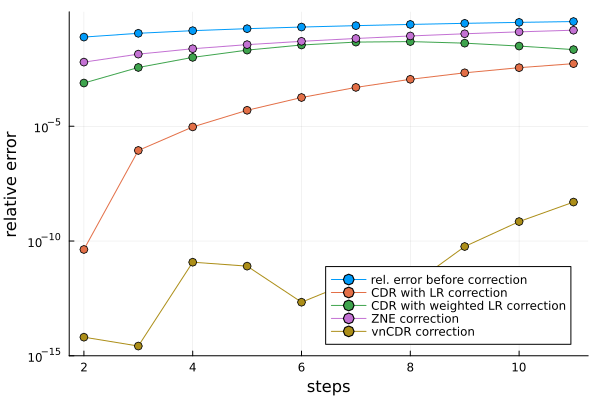

In [26]:
start = 2

plot(start:trotter.steps, rel_before_cdr[start:end], xlabel="steps",ylabel = "relative error", label="rel. error before correction", marker=:o, legend =:bottomright)

# plain CDR and weighted CDR
plot!(start:trotter.steps, rel_after_cdr[start:end], label="CDR with LR correction", marker=:o)
plot!(start:trotter.steps, rel_after_weight_partial_mem[start:end], label="CDR with weighted LR correction", marker=:o)

# plain ZNE
plot!(start:trotter.steps, rel_after_zne[start:end], label="ZNE correction", marker=:o)

# vnCDR
plot!(start:trotter.steps, rel_after_vnCDR[start:end], label="vnCDR correction", marker=:o, yscale=:log10)